# SUAN Pharma data preparation and exploration

## Problem statement:
We are analyzing the data generated from various sensors with in four steps of production of API (Active Pharmaceutical Ingredient).

![Production process](img/batch_process.png)

## Goal:
We are tasked to identify to the variables which increase the yield of the API at the end of the production process. Over the years through iterative improvements, it is said that the yield has been increased. This project could hopefully help in pin-pointing the exact variables and quantify their effects on the yield.

## Data:
We are provided with data collected for each batch executed during the past 9-10 months. For each batch there exists a time-series data of one minute intervals and a static value for the percentage of the yield generated at the end of the batch.

## Challenges:
1. The process is sequential, so is the data collected during the process. For example, when the first step starts the data collection is limited to the first step and maybe the second step as well at some point during the end of the first step, this means that out of the four steps atmost two steps could be active at any given point resulting in nan or 

### Data preparation:
1. For each batch an Excel file containing five sheets is shared each of which can be briefly described as follows:
    1. PO: It contains 3 values, the batch ID, the start and the end times of the batch.
    2. BHV: Data collected from Broth Harvest step is in this sheet, it contains 19 columns
    3. CFF: Data collected from Cross Flow Filtration step is in this sheet, it contains 114 columns
    4. EXT: Data collected from Extraction step is in this sheet, it contains 78 columns
    5. NF: Data collected from Nano Filtration step is in this sheet, it contains 53 columns
2. Firstly all the data from various steps needs to be column binded and then various batches of data needs to be row binded.
###### udf_read_bind() takes care of Steps 1 and 2 among other simple tasks such as object to datetime conversion etc.
3. One thing to note is that sometimes the time variable in the timeseries is occasionally shared in a different format than what is expected by the above function, this has to be taken care of manually
4. Handling bool variables by converting them to 0s and 1s


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from tqdm import tqdm
import glob

In [4]:
file_names = glob.glob('../../../data/input/11_Dataset/**/ODP *.xlsx')
problematic_files = [] # ['../../../data/input/11_Dataset/ODP 100001777_dati_BHV_CFF_NF_EXT .xlsx']
while problematic_files in file_names: file_names.remove(problematic_files)
# list(map(lambda x: x.split('_')[0], list(map(lambda x: x.split(' ')[1], file_names))))

In [30]:
def udf_read_bind(fileNames):
    foo = []
    col_names_list = []
    error_batches = []
    for i in tqdm(fileNames):
        data0 = pd.read_excel(i, sheet_name="BHV")
        data1 = pd.read_excel(i, sheet_name="CFF")
        data2 = pd.read_excel(i, sheet_name="EXT")
        data3 = pd.read_excel(i, sheet_name="NF")
        
        try:
            data = data0.merge(data1)
            data = data.merge(data2)
            data = data.merge(data3)
            data.rename(columns = {'Unnamed: 0' : 'timeseries'}, inplace = True)
            data['timeseries'] = pd.to_datetime(data['timeseries'], format = '%m-%d-%Y %H:%M:%S')
            data.insert(0,'id', i[49:53])
            data['id'] = data['id'].convert_dtypes()
            foo.append(data)
            col_names_list.append(data.columns.values)
        except ValueError:
            error_batches.append(i[49:53])
            continue
        
    appended_data = pd.concat(foo)
    col_names_list = [l.tolist() for l in col_names_list]
    return appended_data, error_batches

def udf_describe(df):
    desc_df = df.describe(include = 'all')
    desc_df.loc['dtype'] = df.dtypes
    desc_df.loc['size'] = len(df)
    desc_df.loc['% count'] = df.isnull().mean()*100
    return desc_df

# def udf_sanitary_check(df):

In [31]:
df, data_errors = udf_read_bind(file_names)
print("The following batches have incompatible data: ", data_errors)
# if any blank columns are created by accident in a spreadsheet software, which wouldn't have any column name, we remove such columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed:')))]
print("How many NaN values exist in the data: ", df.isna().sum().sum())
print("Shape of the data: ",df.shape)

100%|██████████| 40/40 [02:08<00:00,  3.21s/it]


The following batches have incompatible data:  ['1778', '1576']


(47319, 265)

In [40]:
tdf = df.groupby(['id'])['timeseries'].agg(['min', 'max']).reset_index()
tdf.columns = ['id', 'start_date', 'end_date']
tdf['processing_time_mins'] = ((tdf['end_date'] - tdf['start_date'])/pd.Timedelta(minutes = 1))+1
df = tdf.merge(df, how = 'right')
df.insert(5, 'timestamp_index', df.groupby('id').cumcount())

Something is wrong, the input folder has 40 batches of which 2 batches have caused read errors, therefore df must have 38 batches, however it only has 36 as you can see below:

In [55]:
df[['id', 'start_date', 'end_date', 'processing_time_mins']].drop_duplicates().reset_index(drop =True)

id          start_date            end_date  processing_time_mins
0   1770 2021-09-17 17:40:00 2021-09-18 15:39:00            1320.00000
1   1776 2021-09-26 02:32:00 2021-09-26 22:59:00            1228.00000
2   1772 2021-09-20 20:20:00 2021-09-21 15:48:00            1169.00000
3   1773 2021-09-21 19:05:00 2021-09-22 10:09:00             905.00000
4   1774 2021-09-23 17:19:00 2021-09-24 16:12:00            1374.00000
5   1769 2021-09-16 02:45:00 2021-09-17 07:18:00            1714.00000
6   1771 2021-09-19 16:55:00 2021-09-20 15:57:00            1383.00000
7   1775 2021-09-24 20:26:00 2021-09-25 22:27:00            1562.00000
8   1575 2021-08-20 00:00:00 2021-08-21 02:29:00            1590.00000
9   1580 2021-08-26 15:14:00 2021-08-27 11:29:00            1216.00000
10  1579 2021-08-25 00:22:00 2021-08-25 22:29:00            1328.00000
11  1779 2021-09-30 12:35:00 2021-10-01 14:09:00            1535.00000
12  1780 2021-10-01 18:05:00 2021-10-02 22:34:00            1710.00000
13  1578 2021-08-23 22:50:00 2021-08-24 21:09:00            1340.00000
14  1581 2021-08-27 17:02:00 2021-08-28 11:39:00            1118.00000
15  1574 2021-08-18 19:30:00 2021-08-19 19:09:00            1420.00000
16  1695 2021-09-01 17:25:00 2021-09-02 12:19:00            1135.00000
17  1949 2021-10-04 03:20:00 2021-10-05 00:59:00            1300.00000
18  1699 2021-09-06 18:45:00 2021-09-07 18:49:00            1445.00000
19  1698 2021-09-05 15:50:00 2021-09-06 14:29:00            1360.00000
20  1948 2021-10-03 02:35:00 2021-10-04 00:14:00            1300.00000
21  1572 2021-08-16 14:16:00 2021-08-17 13:29:00            1394.00000
22  1697 2021-09-03 17:14:00 2021-09-04 09:29:00             976.00000
23  1584 2021-08-31 18:06:00 2021-09-01 11:39:00            1054.00000
24  1696 2021-09-02 17:18:00 2021-09-03 11:29:00            1092.00000
25  1577 2021-08-22 20:40:00 2021-08-23 18:29:00            1310.00000
26  1582 2021-08-28 16:34:00 2021-08-29 21:29:00            1736.00000
27  1583 2021-08-30 01:03:00 2021-08-30 23:29:00            1347.00000
28  1700 2021-09-07 22:30:00 2021-09-08 19:20:00            1251.00000
29  1702 2021-09-10 03:10:00 2021-09-10 18:19:00             910.00000
30  1768 2021-09-15 01:30:00 2021-09-15 23:09:00            1300.00000
31  1704 2021-09-11 20:25:00 2021-09-12 17:16:00            1252.00000
32  1703 2021-09-10 22:30:00 2021-09-11 16:35:00            1086.00000
33  1705 2021-09-12 20:45:00 2021-09-13 20:25:00            1421.00000
34  1767 2021-09-13 23:30:00 2021-09-14 22:00:00            1351.00000
35  1701 2021-09-08 23:35:00 2021-09-09 22:41:00            1387.00000

In [42]:
df

id          start_date            end_date  processing_time_mins  \
0      1770 2021-09-17 17:40:00 2021-09-18 15:39:00            1320.00000   
1      1770 2021-09-17 17:40:00 2021-09-18 15:39:00            1320.00000   
2      1770 2021-09-17 17:40:00 2021-09-18 15:39:00            1320.00000   
3      1770 2021-09-17 17:40:00 2021-09-18 15:39:00            1320.00000   
4      1770 2021-09-17 17:40:00 2021-09-18 15:39:00            1320.00000   
...     ...                 ...                 ...                   ...   
47314  1701 2021-09-08 23:35:00 2021-09-09 22:41:00            1387.00000   
47315  1701 2021-09-08 23:35:00 2021-09-09 22:41:00            1387.00000   
47316  1701 2021-09-08 23:35:00 2021-09-09 22:41:00            1387.00000   
47317  1701 2021-09-08 23:35:00 2021-09-09 22:41:00            1387.00000   
47318  1701 2021-09-08 23:35:00 2021-09-09 22:41:00            1387.00000   

               timeseries  timestamp_index    101LI636    101WI610  \
0     2021-09-17 17:40:00                0 93997.67969 66777.83594   
1     2021-09-17 17:41:00                1 93923.12500 67153.77344   
2     2021-09-17 17:42:00                2 93652.11719 67524.91406   
3     2021-09-17 17:43:00                3 93172.82031 67845.61719   
4     2021-09-17 17:44:00                4 93076.46094 68226.37500   
...                   ...              ...         ...         ...   
47314 2021-09-09 22:37:00             1382 82405.95313 33070.69922   
47315 2021-09-09 22:38:00             1383 82410.16406 33068.64453   
47316 2021-09-09 22:39:00             1384 82412.42188 33068.34375   
47317 2021-09-09 22:40:00             1385 82406.48438 33060.69922   
47318 2021-09-09 22:41:00             1386 82397.89063 33056.86719   

         306LI606  101AI635  ...  108PI659  108PI662  108PI663  108FI653  \
0         0.00000   5.09890  ...   0.14559  -0.01445   0.11963   0.16632   
1         0.00000   5.10041  ...   0.15442  -0.01962   0.10669   0.06121   
2         0.00000   5.10070  ...   0.15442  -0.00813   0.11589   0.11847   
3         0.00000   5.09922  ...   0.15013  -0.01236   0.11519   0.13286   
4         0.00000   5.10009  ...   0.15484  -0.00707   0.11072   0.00188   
...           ...       ...  ...       ...       ...       ...       ...   
47314 85118.58594   5.30540  ...   1.98089  -0.02625   0.09468   1.78485   
47315 85110.12500   5.30350  ...   6.19787  -0.02625   0.09701   1.82199   
47316 85057.60156   5.30322  ...   6.20957  -0.02559   0.10168   1.98877   
47317 85024.37500   5.30635  ...   6.23108  -0.03219   0.09791   1.98764   
47318 85055.89844   5.30386  ...   6.22694  -0.03354   0.10241   2.13837   

       108FI657  108FI665  108FI669  108FI673  108FI677  108FI681  
0       0.10395   0.08238   0.08989   0.11185   0.11023   0.10765  
1       0.09817   0.08221   0.07135   0.10946   0.10602   0.10403  
2       0.10268   0.08358   0.09620   0.10074   0.11001   0.09704  
3       0.10163   0.08185   0.08779   0.10665   0.10917   0.10366  
4       0.09222   0.08115   0.09085   0.10201   0.11202   0.08596  
...         ...       ...       ...       ...       ...       ...  
47314   1.55033   0.08275   0.07252   0.10943   0.10575   0.09579  
47315   1.65050   0.08176   0.08477   0.10018   0.10283   0.09452  
47316   1.74241   0.08115   0.07711   0.10856   0.10334   0.10498  
47317   1.83296   0.08520   0.07892   0.10680   0.10287   0.09021  
47318   1.87944   0.08472   0.08667   0.10222   0.11002   0.09594  

[47319 rows x 269 columns]

Lets compute mean and mean CI for each batch

In [43]:
batch_id = list(df['id'].unique())
VOI_mean = ['101LI636', 'DIAFTOTALE', '107LI606', '113LI682']
# df[VOI_mean]
#define sample data
lst = []

for i in batch_id:
    # print("Batch: ", i)
    for j in VOI_mean:
        data = df.loc[df['id'] == i, j]
        #create 95% confidence interval for t distribution and normal distribution population mean
        x = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
        y = st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))
        lst.append([i, j, np.mean(data), x[0], x[1], y[0], y[1]])
data = pd.DataFrame(lst, columns= ['batch_id', 'variable', 'mean', 't_dist_mean_lcb', 't_dist_mean_ucb', 'norm_dist_mean_lcb', 'norm_dist_mean_ucb'])


In [45]:
data.loc[data['variable'] == VOI_mean[0]].reset_index(drop=True)

batch_id  variable        mean  t_dist_mean_lcb  t_dist_mean_ucb  \
0      1770  101LI636 62132.28102      60359.23980      63905.32224   
1      1776  101LI636 74216.53564      73091.63927      75341.43200   
2      1772  101LI636 55719.99644      53973.91961      57466.07327   
3      1773  101LI636 46111.35901      43956.07820      48266.63982   
4      1774  101LI636 62676.02285      61068.80739      64283.23831   
5      1769  101LI636 72753.87132      71620.91492      73886.82773   
6      1771  101LI636 56838.34567      55070.95091      58605.74043   
7      1775  101LI636 69324.75908      68002.77884      70646.73931   
8      1575  101LI636 58052.95372      56284.66877      59821.23867   
9      1580  101LI636 60249.14480      58518.40035      61979.88925   
10     1579  101LI636 59873.05979      58102.30075      61643.81883   
11     1779  101LI636 62312.72428      60691.02831      63934.42026   
12     1780  101LI636 70956.27529      69776.41802      72136.13255   
13     1578  101LI636 77208.10429      76169.82693      78246.38166   
14     1581  101LI636 56078.07959      54248.78323      57907.37595   
15     1574  101LI636 66418.65533      65035.76093      67801.54972   
16     1695  101LI636 54330.69758      52433.34485      56228.05032   
17     1949  101LI636 57423.81072      55556.97964      59290.64179   
18     1699  101LI636 66171.42990      64614.68027      67728.17952   
19     1698  101LI636 58611.40623      56834.58082      60388.23163   
20     1948  101LI636 69006.84557      67476.25591      70537.43523   
21     1572  101LI636 58062.70010      56262.31391      59863.08629   
22     1697  101LI636 49281.13266      47145.95119      51416.31413   
23     1584  101LI636 48422.07747      46513.66703      50330.48790   
24     1696  101LI636 55090.15163      53138.79974      57041.50352   
25     1577  101LI636 79453.16679      78706.93265      80199.40093   
26     1582  101LI636 48883.48662      47245.64297      50521.33026   
27     1583  101LI636 52773.88119      50877.99719      54669.76520   
28     1700  101LI636 78008.46849      77142.50294      78874.43403   
29     1702  101LI636 57076.65940      55283.83135      58869.48745   
30     1768  101LI636 67360.45017      65741.20444      68979.69590   
31     1704  101LI636 58758.03518      57080.98046      60435.08990   
32     1703  101LI636 56293.99695      54400.71800      58187.27590   
33     1705  101LI636 67649.74336      66139.95030      69159.53642   
34     1767  101LI636 66986.28370      65529.88530      68442.68211   
35     1701  101LI636 67190.99910      65774.45102      68607.54718   

    norm_dist_mean_lcb  norm_dist_mean_ucb  
0          60360.86678         63903.69525  
1          73092.74890         75340.32237  
2          53975.72898         57464.26390  
3          43958.96384         48263.75419  
4          61070.22421         64281.82149  
5          71621.71543         73886.02722  
6          55072.49878         58604.19256  
7          68003.80386         70645.71429  
8          56286.01568         59819.89176  
9          58520.12446         61978.16513  
10         58103.91584         61642.20373  
11         60692.30785         63933.14072  
12         69777.25362         72135.29695  
13         76170.76544         78245.44314  
14         54250.76539         57905.39379  
15         65036.94048         67800.37017  
16         52435.36993         56226.02524  
17         55558.71906         59288.90237  
18         64615.98513         67726.87467  
19         56836.16329         60386.64917  
20         67477.68204         70536.00910  
21         56263.87822         59861.52197  
22         47148.60175         51413.66357  
23         46515.86060         50328.29433  
24         53140.96454         57039.33872  
25         78707.62265         80198.71094  
26         47246.78554         50520.18769  
27         50879.70200         54668.06039  
28         77143.34143         78873.59554  
29         55286.21851   

In [99]:
data.loc[data['variable'] == VOI_mean[1]].reset_index(drop=True)

batch_id    variable     mean  t_dist_mean_lcb  t_dist_mean_ucb  \
1      1700  DIAFTOTALE  1.43895          1.41070          1.46721   
5      1770  DIAFTOTALE  1.82474          1.79414          1.85534   
9      1776  DIAFTOTALE  1.26297          0.34484          2.18109   
13     1702  DIAFTOTALE  1.59980          1.55420          1.64539   
17     1772  DIAFTOTALE  1.44026          1.40807          1.47244   
21     1768  DIAFTOTALE  0.81885         -0.04238          1.68008   
25     1704  DIAFTOTALE  1.58438          1.54892          1.61984   
29     1773  DIAFTOTALE  1.37796          1.33761          1.41832   
33     1774  DIAFTOTALE -0.63925         -8.03142          6.75291   
37     1703  DIAFTOTALE  1.52479          1.49470          1.55488   
41     1769  DIAFTOTALE  1.63636          1.61575          1.65698   
45     1705  DIAFTOTALE  1.50497          1.47583          1.53410   
49     1767  DIAFTOTALE  1.60939          1.55696          1.66182   
53     1771  DIAFTOTALE  1.45519          1.41939          1.49099   
57     1701  DIAFTOTALE  1.28076          0.69547          1.86605   
61     1775  DIAFTOTALE  1.20048          1.04773          1.35323   

    norm_dist_mean_lcb  norm_dist_mean_ucb  
1              1.41073             1.46718  
5              1.79417             1.85531  
9              0.34574             2.18019  
13             1.55426             1.64533  
17             1.40810             1.47241  
21            -0.04158             1.67928  
25             1.54896             1.61981  
29             1.33766             1.41827  
33            -8.02490             6.74640  
37             1.49473             1.55484  
41             1.61577             1.65696  
45             1.47585             1.53408  
49             1.55700             1.66178  
53             1.41943             1.49096  
57             0.69598             1.86554  
61             1.04785             1.35311

In [100]:
data.loc[data['variable'] == VOI_mean[2]]

batch_id  variable     mean  t_dist_mean_lcb  t_dist_mean_ucb  \
2      1700  107LI606 15.66051         15.29101         16.03001   
6      1770  107LI606 13.27937         13.08469         13.47405   
10     1776  107LI606  8.57062          8.39769          8.74355   
14     1702  107LI606 10.64844         10.37542         10.92146   
18     1772  107LI606 14.88103         14.50817         15.25389   
22     1768  107LI606 23.73461         22.92745         24.54177   
26     1704  107LI606 17.98040         17.38578         18.57502   
30     1773  107LI606 14.66614         14.11316         15.21911   
34     1774  107LI606 16.08573         15.69521         16.47625   
38     1703  107LI606 14.01874         13.74255         14.29493   
42     1769  107LI606 17.48719         17.16158         17.81280   
46     1705  107LI606 21.00980         20.39996         21.61964   
50     1767  107LI606 14.53833         14.28855         14.78812   
54     1771  107LI606 22.16454         21.42536         22.90371   
58     1701  107LI606  6.69588          6.60599          6.78578   
62     1775  107LI606 33.95410         33.10347         34.80473   

    norm_dist_mean_lcb  norm_dist_mean_ucb  
2             15.29137            16.02966  
6             13.08487            13.47387  
10             8.39786             8.74338  
14            10.37578            10.92109  
18            14.50856            15.25351  
22            22.92820            24.54102  
26            17.38635            18.57445  
30            14.11390            15.21837  
34            15.69556            16.47591  
38            13.74286            14.29462  
42            17.16181            17.81257  
46            20.40048            21.61912  
50            14.28877            14.78790  
54            21.42601            22.90307  
58             6.60607             6.78570  
62            33.10413            34.80407

In [101]:
data.loc[data['variable'] == VOI_mean[3]]

batch_id  variable     mean  t_dist_mean_lcb  t_dist_mean_ucb  \
3      1700  113LI682 19.28771         18.98663         19.58880   
7      1770  113LI682 18.24748         17.86281         18.63216   
11     1776  113LI682 17.67671         17.34741         18.00602   
15     1702  113LI682 20.69357         20.10210         21.28505   
19     1772  113LI682 19.27063         18.94757         19.59370   
23     1768  113LI682 20.00150         19.64087         20.36212   
27     1704  113LI682 17.61777         17.33533         17.90022   
31     1773  113LI682 17.25753         16.87382         17.64124   
35     1774  113LI682 19.54521         19.24180         19.84861   
39     1703  113LI682 18.61508         18.24148         18.98868   
43     1769  113LI682 24.04969         23.74751         24.35186   
47     1705  113LI682 17.97996         17.73676         18.22316   
51     1767  113LI682 18.87951         18.57725         19.18178   
55     1771  113LI682 18.55077         18.29364         18.80789   
59     1701  113LI682 21.81772         21.46865         22.16680   
63     1775  113LI682 17.94910         17.70892         18.18928   

    norm_dist_mean_lcb  norm_dist_mean_ucb  
3             18.98692            19.58851  
7             17.86316            18.63181  
11            17.34773            18.00569  
15            20.10289            21.28426  
19            18.94790            19.59336  
23            19.64120            20.36179  
27            17.33561            17.89994  
31            16.87434            17.64073  
35            19.24207            19.84834  
39            18.24189            18.98826  
43            23.74773            24.35164  
47            17.73697            18.22295  
51            18.57752            19.18150  
55            18.29387            18.80767  
59            21.46895            22.16649  
63            17.70910            18.18909

In [104]:
for i in VOI_mean:
    fig = px.line(df, x="timestamp_index", y=i, color='id')
    fig.show()

As per the guidelines document, the start and end of each step in the process can be identified using the above 4 variables,
1. DIAFTOTALE will be used to identify when the CFF process completes, also considering all the batches its distribution is almost constant.
2. 107LI606 is for NF, notice that the distributions for each batch are not consistent as the values increase. It is said that the process starts when the values jump from 0 to a certain value quickly, which can be identified from the plot above.
3. 113LI682 is for EXT

In [28]:
for i in VOI_mean:
    fig = px.box(df, x="id", y= i, points='all')
    fig.update_xaxes(type='category')
    fig.show()

Lets take a look at ECDFs for the 4 variables above:

In [45]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

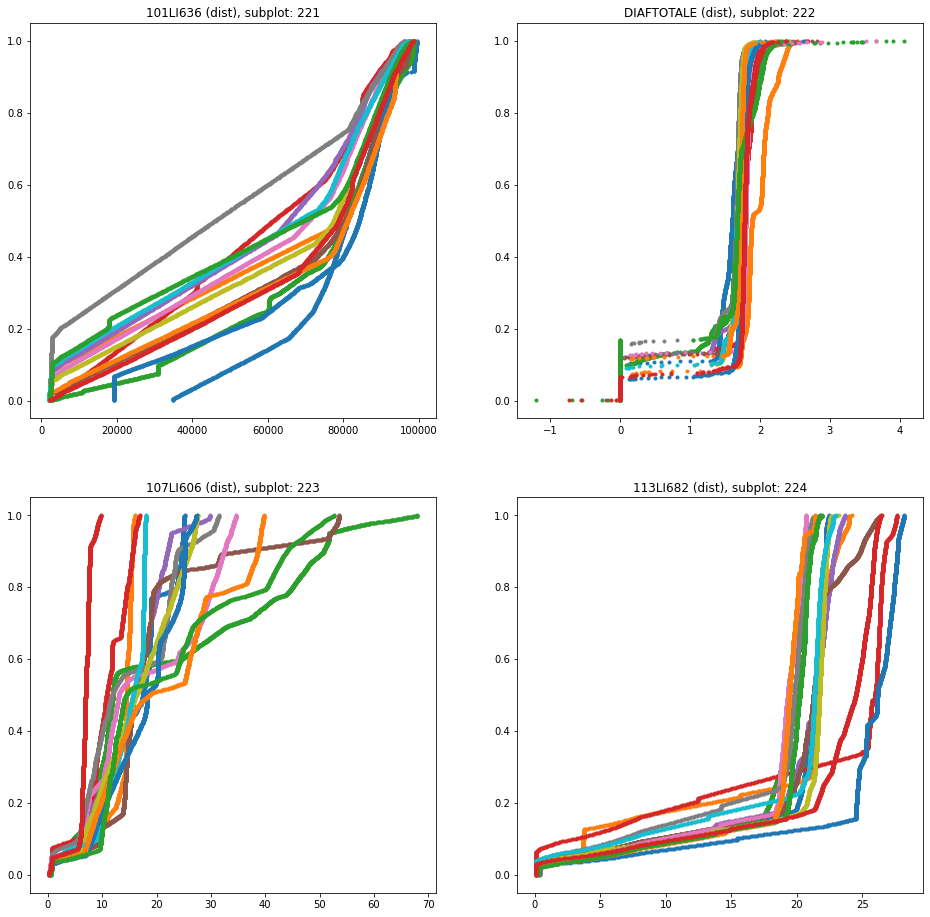

In [104]:
import math

a = 2  # number of rows
b = 2  # number of columns
fig = plt.figure(figsize=(16,16))

for i in batch_id:
    c = 1  # initialize plot counter
    for j in VOI_mean:
        plt.subplot(a, b, c)
        plt.title('{} (dist), subplot: {}{}{}'.format(j, a, b, c))
        # if condition to treat 'DIAFTOTALE' variable outliers
        if j == 'DIAFTOTALE':
            z= df.loc[df['id'] == i].copy()
            z.loc[z[j] > 5, j] = 0
            z.loc[z[j] < -2, j] = 0
            x, y = ecdf(z[j])
        else:
            x, y = ecdf(df.loc[df['id'] == i, j])
        plt.scatter(x = x, y = y, linewidths= 1, marker='.');
        c = c+1

In [51]:
col_irregularities = df.nunique()[df.nunique()<=1].keys()
for i in col_irregularities:
    print("Column {col_} has just these values: {list_}".format(col_=i, list_=df[i].unique()))

Column 158PIC678_823 has just these values: [0.]
Column 118LS960 has just these values: [False]
Column 118FI913 has just these values: [32000.]


In the above output we can see 4 variables with Device type abbrevation as "ZLL" which is not mentioned in the guideline document shared with the team, even if we consider 118Z to be the unit number, there is no LL abbrevation. We may need more data to take a call on whether to remove variables which have one unique values apart from nan (there are 3 such variables above). Anyways for now bool variables are converted to int/float by converting them to 0s and 1s.

In [54]:
# lets remove columns with constant values
# df.drop(columns = col_irregularities.values, inplace= True)

In [66]:
cols_BHV = ['101LI636', '101WI610', '306LI606', '101AI635', '101AI605', '101TI607', '101TI637', '306TI604', '306LI606', '158PI678', '101PI602', '101PI603', '158PIC678_823', '158PIC678_824', '99TI620', '99PI621', '99AI622', '99AI623', '99AI624']
cols_CFF = ['158FI652', '158FI654', '158FI656', '158FI666', '158FI667', '158FI679P', '158PI651', '158PI653', '158PI655', '158PI663', '158PI678', '158TI650', '158TIC650', '159FI652', '159FI654', '159FI656', '159FI666', '159FI667', '159PI651', '159PI653', '159PI655', '159PI663', '159TI650', '159TIC650', '160FI652', '160FI654', '160FI656', '160FI666', '160FI667', '160PI651', '160PI653', '160PI655', '160PI663', '160TI650', '160TIC650', '161FI652', '161FI654', '161FI656', '161FI666', '161FI667', '161PI651', '161PI653', '161PI655', '161PI663', '161TI650', '161TIC650', '162FI652', '162FI654', '162FI656', '162FI666', '162FI667', '162PI651', '162PI653', '162PI655', '162PI663', '162TI650', '162TIC650', '163FI652', '163FI654', '163FI656', '163FI666', '163FI667', '163PI651', '163PI653', '163PI655', '163PI663', '163TI650', '163TIC650', '164FI652', '164FI654', '164FI656', '164FI666', '164FI667', '164PI651', '164PI653', '164PI655', '164PI663', '164TI650', '164TIC650', '165FI652', '165FI654', '165FI656', '165FI666', '165FI667', '165PI651', '165PI653', '165PI655', '165PI663', '165TI650', '165TIC650', '158CAL4551', '158CAL4552', '159CAL4551', '159CAL4552', '160CAL4551', '160CAL4552', '161CAL4551', '161CAL4552', '162CAL4551', '162CAL4552', '163CAL4551', '163CAL4552', '164CAL4551', '164CAL4552', '165CAL4551', '165CAL4552', 'DWTOTALE', 'PERMTOTALE', 'DIAFTOTALE', 'CONCTOTALE', '158TI684', '158TI670', '158TI672', '158TI673']
cols_NF = ['107LI606', '107TI607', '107PI608', '107AI610', '107TI652', '107TI656', '107TI660', '107TI664', '107TI668', '107PI650', '107PI651', '107PI654', '107PI655', '107PI658', '107PI659', '107PI682A', '107PI684A', '107PI686A', '107PI688A', '107PI690A', '107PI692A', '107FI681A', '107FI696A', '107FI685A', '107FI689A', '107FI693A', '107AI672', '108AI610', '107AI673A', '107AI674A', '107AI677A', '108AI611', '108AI612', '108AI613', '108TI652', '108TI656', '108TI660', '108TI664', '108PI650', '108PI651', '108PI654', '108PI655', '108PI658', '108PI659', '108PI662', '108PI663', '108FI653', '108FI657', '108FI665', '108FI669', '108FI673', '108FI677', '108FI681']
cols_EXT = ['118PI619', '118PI618', '118PI914', '118PI950', '118PI954', '118PI915', '118PI916', '118PI917', '118TI609', '118TI970', '118TI971', '118TI972', '118TI973', '118TI977', '118TI978', '118EI610', '118EI620', '118EI630', '118EI640', '118SI613', '118SI623', '118SI633', '118SI643', '118FI983', '118FI638', '118AI611', '118AI621', '118AI631', '118AI641', '118AI627', '118AI616', '118FI602', '118FI601', '118FI602', '109LI606', '109FI616', '118FI982', '118FI606', '118FIC606', '118CV502', '118CV501', '890PI610', '118FQ602', '118ZLH303', '118LS960', '118LS690', '118ZLL417', '118ZLL427', '118ZLL437', '118ZLL447', '118FI912', '118FI913', '118PI629', '118PI628', '118PI924', '118PI951', '118PI964', '118PI925', '118PI926', '118PI927', '118PI639', '118PI638', '118PI934', '118PI952', '118PI974', '118PI935', '118PI936', '118PI937', '118PI649', '118PI648', '118PI944', '118PI953', '118PI984', '118PI945', '118PI946', '118PI947', '113LI682', '113LI682']

In [35]:
udf_describe(df[col_irregularities]).T

count unique    top   freq        mean     std  \
158PIC678_823 20613.00000    NaN    NaN    NaN     0.00000 0.00000   
118ZLH303           20613      2  False  19821         NaN     NaN   
118LS960            20613      1  False  20613         NaN     NaN   
118LS690            20613      2  False  20519         NaN     NaN   
118ZLL417           20613      2  False  17234         NaN     NaN   
118ZLL427           20613      2  False  17114         NaN     NaN   
118ZLL437           20613      2  False  16655         NaN     NaN   
118ZLL447           20613      2  False  17780         NaN     NaN   
118FI913      20613.00000    NaN    NaN    NaN 32000.00000 0.00000   

                      min         25%         50%         75%         max  \
158PIC678_823     0.00000     0.00000     0.00000     0.00000     0.00000   
118ZLH303             NaN         NaN         NaN         NaN         NaN   
118LS960              NaN         NaN         NaN         NaN         NaN   
118LS690              NaN         NaN         NaN         NaN         NaN   
118ZLL417             NaN         NaN         NaN         NaN         NaN   
118ZLL427             NaN         NaN         NaN         NaN         NaN   
118ZLL437             NaN         NaN         NaN         NaN         NaN   
118ZLL447             NaN         NaN         NaN         NaN         NaN   
118FI913      32000.00000 32000.00000 32000.00000 32000.00000 32000.00000   

                 dtype   size % count  
158PIC678_823  float64  20613 0.00000  
118ZLH303         bool  20613 0.00000  
118LS960          bool  20613 0.00000  
118LS690          bool  20613 0.00000  
118ZLL417         bool  20613 0.00000  
118ZLL427         bool  20613 0.00000  
118ZLL437         bool  20613 0.00000  
118ZLL447         bool  20613 0.00000  
118FI913       float64  20613 0.00000

In [39]:
describe_df = udf_describe(df).T
describe_df.loc[describe_df['dtype'] == 'bool']

/var/folders/6s/f25fqpzn1y55r8yt0d82xjlr0000gn/T/ipykernel_15840/3105901146.py:34: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count unique    top   freq first last mean  std  min  25%  50%  \
118ZLH303  20613      2  False  19821   NaT  NaT  NaN  NaN  NaN  NaN  NaN   
118LS960   20613      1  False  20613   NaT  NaT  NaN  NaN  NaN  NaN  NaN   
118LS690   20613      2  False  20519   NaT  NaT  NaN  NaN  NaN  NaN  NaN   
118ZLL417  20613      2  False  17234   NaT  NaT  NaN  NaN  NaN  NaN  NaN   
118ZLL427  20613      2  False  17114   NaT  NaT  NaN  NaN  NaN  NaN  NaN   
118ZLL437  20613      2  False  16655   NaT  NaT  NaN  NaN  NaN  NaN  NaN   
118ZLL447  20613      2  False  17780   NaT  NaT  NaN  NaN  NaN  NaN  NaN   

           75%  max dtype   size % count  
118ZLH303  NaN  NaN  bool  20613 0.00000  
118LS960   NaN  NaN  bool  20613 0.00000  
118LS690   NaN  NaN  bool  20613 0.00000  
118ZLL417  NaN  NaN  bool  20613 0.00000  
118ZLL427  NaN  NaN  bool  20613 0.00000  
118ZLL437  NaN  NaN  bool  20613 0.00000  
118ZLL447  NaN  NaN  bool  20613 0.00000

What do the above bool variables mean?

In [40]:
x_df = df.groupby(['id', 'start_date', 'end_date', 'processing_time_mins']).describe()
x_df.columns = ['_'.join(col).strip() for col in x_df.columns.values]

In [41]:
x_df

101LI636_count  \
id   start_date          end_date            processing_time_mins                   
1700 2021-09-07 22:30:00 2021-09-08 19:20:00 1251.00000                1251.00000   
1701 2021-09-08 23:35:00 2021-09-09 22:41:00 1387.00000                1387.00000   
1702 2021-09-10 03:10:00 2021-09-10 18:19:00 910.00000                  910.00000   
1703 2021-09-10 22:30:00 2021-09-11 16:35:00 1086.00000                1086.00000   
1704 2021-09-11 20:25:00 2021-09-12 17:16:00 1252.00000                1252.00000   
1705 2021-09-12 20:45:00 2021-09-13 20:25:00 1421.00000                1421.00000   
1767 2021-09-13 23:30:00 2021-09-14 22:00:00 1351.00000                1351.00000   
1768 2021-09-15 01:30:00 2021-09-15 23:09:00 1300.00000                1300.00000   
1769 2021-09-16 02:45:00 2021-09-17 07:18:00 1714.00000                1714.00000   
1770 2021-09-17 17:40:00 2021-09-18 15:39:00 1320.00000                1320.00000   
1771 2021-09-19 16:55:00 2021-09-20 15:57:00 1383.00000                1383.00000   
1772 2021-09-20 20:20:00 2021-09-21 15:48:00 1169.00000                1169.00000   
1773 2021-09-21 19:05:00 2021-09-22 10:09:00 905.00000                  905.00000   
1774 2021-09-23 17:19:00 2021-09-24 16:12:00 1374.00000                1374.00000   
1775 2021-09-24 20:26:00 2021-09-25 22:27:00 1562.00000                1562.00000   
1776 2021-09-26 02:32:00 2021-09-26 22:59:00 1228.00000                1228.00000   

                                                                   101LI636_mean  \
id   start_date          end_date            processing_time_mins                  
1700 2021-09-07 22:30:00 2021-09-08 19:20:00 1251.00000              78008.46849   
1701 2021-09-08 23:35:00 2021-09-09 22:41:00 1387.00000              67190.99910   
1702 2021-09-10 03:10:00 2021-09-10 18:19:00 910.00000               57076.65940   
1703 2021-09-10 22:30:00 2021-09-11 16:35:00 1086.00000              56293.99695   
1704 2021-09-11 20:25:00 2021-09-12 17:16:00 1252.00000              58758.03518   
1705 2021-09-12 20:45:00 2021-09-13 20:25:00 1421.00000              67649.74336   
1767 2021-09-13 23:30:00 2021-09-14 22:00:00 1351.00000              66986.28370   
1768 2021-09-15 01:30:00 2021-09-15 23:09:00 1300.00000              67360.45017   
1769 2021-09-16 02:45:00 2021-09-17 07:18:00 1714.00000              72753.87132   
1770 2021-09-17 17:40:00 2021-09-18 15:39:00 1320.00000              62132.28102   
1771 2021-09-19 16:55:00 2021-09-20 15:57:00 1383.00000              56838.34567   
1772 2021-09-20 20:20:00 2021-09-21 15:48:00 1169.00000              55719.99644   
1773 2021-09-21 19:05:00 2021-09-22 10:09:00 905.00000               46111.35901   
1774 2021-09-23 17:19:00 2021-09-24 16:12:00 1374.00000              62676.02285   
1775 2021-09-24 20:26:00 2021-09-25 22:27:00 1562.00000              69324.75908   
1776 2021-09-26 02:32:00 2021-09-26 22:59:00 1228.00000              74216.53564   

                                                                   101LI636_std  \
id   start_date          end_date            processing_time_mins                 
1700 2021-09-07 22:30:00 2021-09-08 19:20:00 1251.00000             15612.06883   
1701 2021-09-08 23:35:00 2021-09-09 22:41:00 1387.00000             26893.17255   
1702 2021-09-10 03:10:00 2021-09-10 18:19:00 910.00000              27557.04168   
1703 2021-09-10 22:30:00 2021-09-11 16:35:00 1086.00000             31797.77214   
1704 2021-09-11 20:25:00 2021-09-12 17:16:00 1252.00000             30246.90357   
1705 2021-09-12 20:45:00 2021-09-13 20:25:00 1421.00000             29013.22738   
1767 2021-09-13 23:30:00 2021-09-14 22:00:00 1351.00000             27287.90754   
1768 2021-09-15 01:30:00 2021-09-15 23:09:00 1300.00000             29759.90245   
1769 2021-09-16 02:45:00 2021-09-17 07:18:00 1714.00000             23914.62352   
1770 2021-09-17 17:40:00 2021-09-18 15:39:00 1320.00000             32836.66217   
1771 2021-09-19 16:55:00 20

In [77]:
def plot_corr(df,size=10):
    """Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
    """

    corr = df.corr()
    corr = corr.dropna(how = 'all')
    corr = corr.dropna(how = 'all', axis=1)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

In [83]:
df.corr()

processing_time_mins  101LI636  101WI610  306LI606  \
processing_time_mins               1.00000   0.15797   0.14763   0.03447   
101LI636                           0.15797   1.00000   0.03348  -0.31306   
101WI610                           0.14763   0.03348   1.00000   0.45154   
306LI606                           0.03447  -0.31306   0.45154   1.00000   
101AI635                           0.14219   0.47022  -0.03579  -0.05707   
...                                    ...       ...       ...       ...   
108FI665                           0.07901  -0.05834   0.06740   0.10835   
108FI669                           0.05543  -0.04817   0.08851   0.08814   
108FI673                           0.06647  -0.05634   0.08700   0.08017   
108FI677                           0.08245  -0.05424   0.06727   0.05262   
108FI681                           0.10281   0.03451   0.20232   0.11087   

                      101AI635  101AI605  101TI607  101TI637  306TI604  \
processing_time_mins   0.14219  -0.01785   0.08760   0.07427   0.08882   
101LI636               0.47022  -0.29696  -0.43892  -0.02934  -0.11019   
101WI610              -0.03579   0.06024   0.20106   0.33523   0.34331   
306LI606              -0.05707   0.00365   0.08577   0.05723   0.56439   
101AI635               1.00000  -0.08653  -0.23907   0.00041  -0.08817   
...                        ...       ...       ...       ...       ...   
108FI665               0.08112   0.15325   0.03938   0.00361  -0.02514   
108FI669               0.07889   0.15704   0.04009   0.00033  -0.02038   
108FI673               0.09361   0.16519   0.04068   0.01529  -0.01945   
108FI677               0.08893   0.15298   0.04296   0.02942  -0.02667   
108FI681              -0.02367  -0.00416   0.09674   0.16930   0.19043   

                      306LI606.1  ...  108PI659  108PI662  108PI663  108FI653  \
processing_time_mins     0.03447  ...   0.11860   0.11691   0.11890   0.09974   
101LI636                -0.31306  ...  -0.09256  -0.09220  -0.09388  -0.05302   
101WI610                 0.45154  ...   0.03001   0.03322   0.02997   0.06197   
306LI606                 1.00000  ...   0.11920   0.11712   0.11852   0.10237   
101AI635                -0.05707  ...   0.07051   0.07000   0.06804   0.08513   
...                          ...  ...       ...       ...       ...       ...   
108FI665                 0.10835  ...   0.90340   0.93510   0.92333   0.93845   
108FI669                 0.08814  ...   0.78231   0.81572   0.79788   0.85873   
108FI673                 0.08017  ...   0.68955   0.70502   0.69001   0.76102   
108FI677                 0.05262  ...   0.54728   0.56150   0.54820   0.60669   
108FI681                 0.11087  ...   0.04944   0.04915   0.04843   0.06188   

                      108FI657  108FI665  108FI669  108FI673  108FI677  \
processing_time_mins   0.08628   0.07901   0.05543   0.06647   0.08245   
101LI636              -0.04466  -0.05834  -0.04817  -0.05634  -0.05424   
101WI610               0.05593   0.06740   0.08851   0.08700   0.06727   
306LI606               0.09852   0.10835   0.08814   0.08017   0.05262   
101AI635               0.08634   0.08112   0.07889   0.09361   0.08893   
...                        ...       ...       ...       ...       ...   
108FI665               0.95014   1.00000   0.93300   0.79985   0.63467   
108FI669               0.87475   0.93300   1.00000   0.84941   0.69614   
108FI673               0.77405   0.79985   0.84941   1.00000   0.84334   
108FI677               0.61453   0.63467   0.69614   0.84334   1.00000   
108FI681               0.05746   0.06019   0.05616   0.06103   0.05188   

                      108FI681  
processing_time_mins   0.10281  
101LI636               0.03451  
101WI610               0.20232  
306LI606               0.11087  
101AI635              -0.02367  
...                        ...  
108FI665               0.06019  
108FI669               0.05616  
108FI673               0.06103  
108FI677               0.051

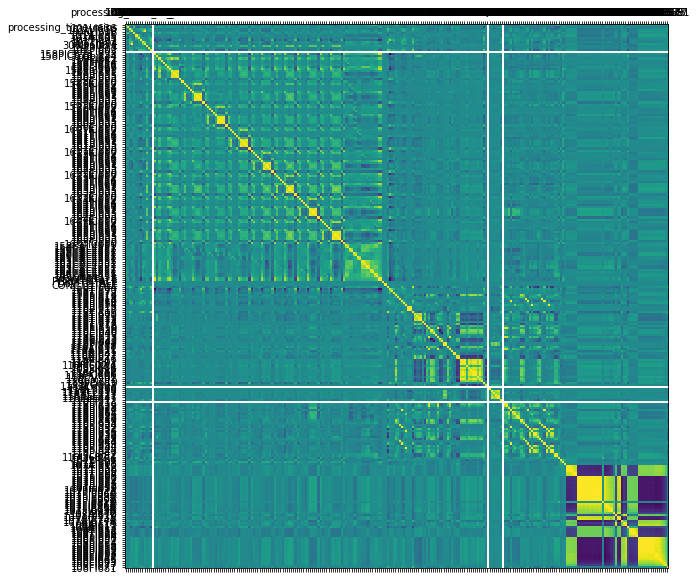

In [81]:
plot_corr(df)

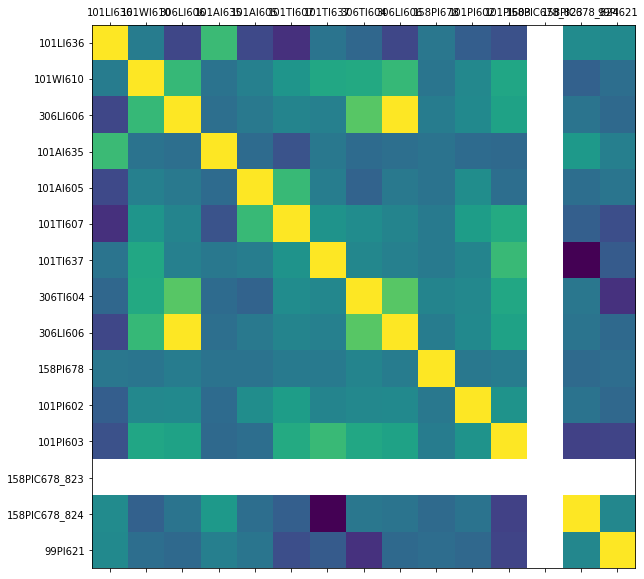

In [84]:
# cols_BHV = [x for x in cols_BHV if (x not in col_irregularities)]
plot_corr(df[cols_BHV])

In [87]:
df[cols_NF].corr()

107LI606  107TI607  107PI608  107AI610  107TI652  107TI656  \
107LI606    1.00000  -0.08417   0.07402   0.06388   0.05785   0.06617   
107TI607   -0.08417   1.00000   0.41339   0.26706   0.10514   0.09831   
107PI608    0.07402   0.41339   1.00000   0.07698   0.10624   0.10222   
107AI610    0.06388   0.26706   0.07698   1.00000   0.04112   0.04435   
107TI652    0.05785   0.10514   0.10624   0.04112   1.00000   0.98301   
107TI656    0.06617   0.09831   0.10222   0.04435   0.98301   1.00000   
107TI660    0.07996   0.08532   0.09987   0.05029   0.94994   0.97284   
107TI664    0.08672   0.08850   0.09573   0.05536   0.84195   0.86293   
107TI668    0.09293   0.09211   0.09273   0.05543   0.81155   0.83277   
107PI650    0.03419  -0.09911  -0.03837  -0.01670  -0.69478  -0.69089   
107PI651    0.03512  -0.09835  -0.03707  -0.01531  -0.68403  -0.68019   
107PI654    0.03729  -0.10146  -0.03979  -0.01627  -0.69268  -0.68686   
107PI655    0.03802  -0.10010  -0.03798  -0.01495  -0.68185  -0.67587   
107PI658    0.03879  -0.10486  -0.04129  -0.01604  -0.69745  -0.69084   
107PI659    0.03925  -0.10285  -0.03917  -0.01491  -0.68592  -0.67910   
107PI682A   0.03893  -0.10311  -0.04344  -0.02317  -0.72063  -0.71454   
107PI684A   0.03879  -0.10044  -0.04162  -0.02261  -0.70959  -0.70333   
107PI686A   0.03756  -0.10233  -0.04285  -0.02860  -0.72313  -0.71691   
107PI688A   0.03738  -0.09986  -0.04168  -0.02812  -0.71272  -0.70633   
107PI690A   0.03713  -0.10171  -0.04313  -0.03475  -0.72692  -0.72068   
107PI692A   0.03737  -0.09895  -0.04179  -0.03409  -0.71527  -0.70885   
107FI681A   0.37597  -0.01340   0.09186  -0.02410   0.19382   0.19296   
107FI696A   0.00797  -0.11840  -0.06538  -0.03025  -0.77030  -0.76563   
107FI685A   0.01995  -0.12485  -0.04962  -0.02505  -0.73378  -0.73051   
107FI689A   0.01282  -0.11713  -0.08209  -0.04547  -0.70875  -0.70539   
107FI693A   0.03988  -0.10358  -0.08090  -0.05928  -0.63841  -0.63448   
107AI672    0.12892  -0.08084  -0.01791   0.01172  -0.17436  -0.19107   
108AI610    0.21966   0.03160   0.12600   0.07705   0.38579   0.38550   
107AI673A   0.06731  -0.10375  -0.05931   0.00370  -0.51949  -0.51452   
107AI674A   0.06529  -0.10931  -0.04063  -0.01233  -0.53536  -0.54118   
107AI677A  -0.26195   0.10313   0.08114   0.08620   0.60318   0.59773   
108AI611    0.18041  -0.02042   0.11264   0.06930   0.52829   0.52832   
108AI612    0.22279   0.01757   0.06704   0.05412   0.58184   0.58175   
108AI613   -0.06779  -0.05134   0.06629   0.00932  -0.42672  -0.42836   
108TI652   -0.02164   0.12275  -0.01000   0.01283  -0.54427  -0.54448   
108TI656   -0.01126   0.09444  -0.03275   0.01431  -0.54205  -0.54223   
108TI660   -0.00179   0.03945  -0.05217   0.01101  -0.54163  -0.54178   
108TI664   -0.01714   0.00350  -0.04635   0.00112  -0.53094  -0.53104   
108PI650    0.18375  -0.01760   0.03849   0.04828   0.65457   0.65527   
108PI651    0.18370  -0.02276   0.03350   0.04701   0.64283   0.64349   
108PI654    0.18718  -0.02431   0.03224   0.04401   0.65289   0.65360   
108PI655    0.18655  -0.02791   0.02850   0.04347   0.64176   0.64242   
108PI658    0.18786  -0.03476   0.02577   0.03914   0.65101   0.65173   
108PI659    0.18680  -0.03623   0.02335   0.03880   0.64096   0.64163   
108PI662    0.18653  -0.04314   0.02621   0.03361   0.65051   0.65125   
108PI663    0.18527  -0.04334   0.02355   0.03344   0.63944   0.64014   
108FI653    0.16650  -0.00822   0.04061   0.04753   0.70023   0.70058   
108FI657    0.13742  -0.01885   0.03411   0.03990   0.70558   0.70539   
108FI665    0.12000  -0.03768   0.01720   0.02663   0.70742   0.70723   
108FI669    0.10666  -0.03335   0.02416   0.02466   0.68813   0.68747   
108FI673    0.11059  -0.02366   0.02425   0.00932   0.62914   0.63029   
108FI677    0.12899  -0.00866   0.02624  -0.00791   0.50471   0.50743   
108FI681   -0.04893   0.04613   0.01306   0.01530   0.07266   0.07160   

           107TI660  107TI664  107TI668  107PI650  ...  108PI659  10

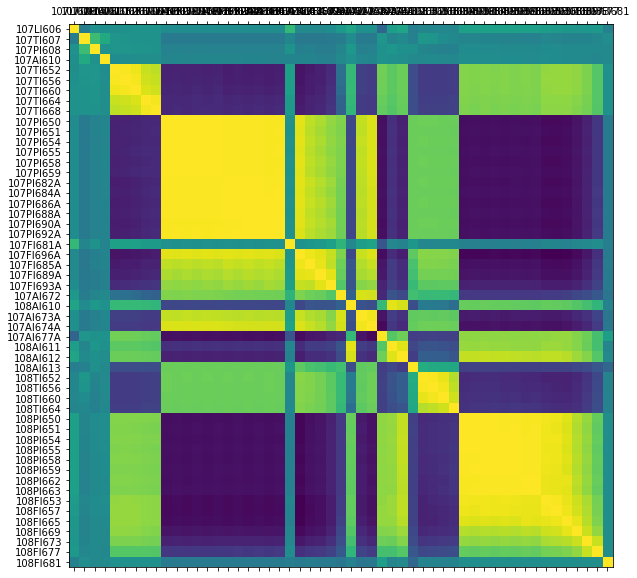

In [86]:
plot_corr(df[cols_NF])

In [80]:
corr_BHV

101LI636  101WI610  306LI606  101AI635  101AI605  101TI607  \
101LI636        1.00000   0.03348  -0.31306   0.47022  -0.29696  -0.43892   
101WI610        0.03348   1.00000   0.45154  -0.03579   0.06024   0.20106   
306LI606       -0.31306   0.45154   1.00000  -0.05707   0.00365   0.08577   
101AI635        0.47022  -0.03579  -0.05707   1.00000  -0.08653  -0.23907   
101AI605       -0.29696   0.06024   0.00365  -0.08653   1.00000   0.45293   
101TI607       -0.43892   0.20106   0.08577  -0.23907   0.45293   1.00000   
101TI637       -0.02934   0.33523   0.05723   0.00041   0.03823   0.18788   
306TI604       -0.11019   0.34331   0.56439  -0.08817  -0.13872   0.14413   
306LI606       -0.31306   0.45154   1.00000  -0.05707   0.00365   0.08577   
158PI678       -0.00934  -0.01809   0.03106  -0.03421  -0.03080   0.00997   
101PI602       -0.16930   0.11176   0.12607  -0.08256   0.15038   0.26312   
101PI603       -0.25750   0.31672   0.29150  -0.09592  -0.06810   0.35162   
158PIC678_824   0.13581  -0.14712  -0.02719   0.22819  -0.06635  -0.16282   
99PI621         0.12588  -0.06684  -0.10013   0.05389  -0.01894  -0.26550   

               101TI637  306TI604  306LI606  158PI678  101PI602  101PI603  \
101LI636       -0.02934  -0.11019  -0.31306  -0.00934  -0.16930  -0.25750   
101WI610        0.33523   0.34331   0.45154  -0.01809   0.11176   0.31672   
306LI606        0.05723   0.56439   1.00000   0.03106   0.12607   0.29150   
101AI635        0.00041  -0.08817  -0.05707  -0.03421  -0.08256  -0.09592   
101AI605        0.03823  -0.13872   0.00365  -0.03080   0.15038  -0.06810   
101TI607        0.18788   0.14413   0.08577   0.00997   0.26312   0.35162   
101TI637        1.00000   0.10553   0.05723   0.01795   0.08124   0.46082   
306TI604        0.10553   1.00000   0.56439   0.08708   0.11190   0.32972   
306LI606        0.05723   0.56439   1.00000   0.03106   0.12607   0.29150   
158PI678        0.01795   0.08708   0.03106   1.00000   0.00101   0.03217   
101PI602        0.08124   0.11190   0.12607   0.00101   1.00000   0.19071   
101PI603        0.46082   0.32972   0.29150   0.03217   0.19071   1.00000   
158PIC678_824  -0.66830  -0.00652  -0.02719  -0.09368  -0.03356  -0.34647   
99PI621        -0.18805  -0.42926  -0.10013  -0.06962  -0.10384  -0.32361   

               158PIC678_824  99PI621  
101LI636             0.13581  0.12588  
101WI610            -0.14712 -0.06684  
306LI606            -0.02719 -0.10013  
101AI635             0.22819  0.05389  
101AI605            -0.06635 -0.01894  
101TI607            -0.16282 -0.26550  
101TI637            -0.66830 -0.18805  
306TI604            -0.00652 -0.42926  
306LI606            -0.02719 -0.10013  
158PI678            -0.09368 -0.06962  
101PI602            -0.03356 -0.10384  
101PI603            -0.34647 -0.32361  
158PIC678_824        1.00000  0.10554  
99PI621              0.10554  1.00000

In [73]:
# plotly corr plot, takes a long time to run
# import chart_studio.plotly as py
# import plotly.graph_objs as go

# cols_BHV = [x for x in cols_BHV if (x not in col_irregularities)]
# corr_BHV = df[cols_BHV].corr()

# trace = go.Heatmap(z=corr_BHV.values,
#                   x=corr_BHV.index.values,
#                   y=corr_BHV.columns.values)
# corr_data=[trace]
# py.iplot(corr_data, filename='basic-heatmap')

In [74]:
corr_BHV

101LI636  101WI610  306LI606  101AI635  101AI605  101TI607  \
101LI636        1.00000   0.03348  -0.31306   0.47022  -0.29696  -0.43892   
101WI610        0.03348   1.00000   0.45154  -0.03579   0.06024   0.20106   
306LI606       -0.31306   0.45154   1.00000  -0.05707   0.00365   0.08577   
101AI635        0.47022  -0.03579  -0.05707   1.00000  -0.08653  -0.23907   
101AI605       -0.29696   0.06024   0.00365  -0.08653   1.00000   0.45293   
101TI607       -0.43892   0.20106   0.08577  -0.23907   0.45293   1.00000   
101TI637       -0.02934   0.33523   0.05723   0.00041   0.03823   0.18788   
306TI604       -0.11019   0.34331   0.56439  -0.08817  -0.13872   0.14413   
306LI606       -0.31306   0.45154   1.00000  -0.05707   0.00365   0.08577   
158PI678       -0.00934  -0.01809   0.03106  -0.03421  -0.03080   0.00997   
101PI602       -0.16930   0.11176   0.12607  -0.08256   0.15038   0.26312   
101PI603       -0.25750   0.31672   0.29150  -0.09592  -0.06810   0.35162   
158PIC678_824   0.13581  -0.14712  -0.02719   0.22819  -0.06635  -0.16282   
99PI621         0.12588  -0.06684  -0.10013   0.05389  -0.01894  -0.26550   

               101TI637  306TI604  306LI606  158PI678  101PI602  101PI603  \
101LI636       -0.02934  -0.11019  -0.31306  -0.00934  -0.16930  -0.25750   
101WI610        0.33523   0.34331   0.45154  -0.01809   0.11176   0.31672   
306LI606        0.05723   0.56439   1.00000   0.03106   0.12607   0.29150   
101AI635        0.00041  -0.08817  -0.05707  -0.03421  -0.08256  -0.09592   
101AI605        0.03823  -0.13872   0.00365  -0.03080   0.15038  -0.06810   
101TI607        0.18788   0.14413   0.08577   0.00997   0.26312   0.35162   
101TI637        1.00000   0.10553   0.05723   0.01795   0.08124   0.46082   
306TI604        0.10553   1.00000   0.56439   0.08708   0.11190   0.32972   
306LI606        0.05723   0.56439   1.00000   0.03106   0.12607   0.29150   
158PI678        0.01795   0.08708   0.03106   1.00000   0.00101   0.03217   
101PI602        0.08124   0.11190   0.12607   0.00101   1.00000   0.19071   
101PI603        0.46082   0.32972   0.29150   0.03217   0.19071   1.00000   
158PIC678_824  -0.66830  -0.00652  -0.02719  -0.09368  -0.03356  -0.34647   
99PI621        -0.18805  -0.42926  -0.10013  -0.06962  -0.10384  -0.32361   

               158PIC678_823  158PIC678_824  99PI621  
101LI636                 NaN        0.13581  0.12588  
101WI610                 NaN       -0.14712 -0.06684  
306LI606                 NaN       -0.02719 -0.10013  
101AI635                 NaN        0.22819  0.05389  
101AI605                 NaN       -0.06635 -0.01894  
101TI607                 NaN       -0.16282 -0.26550  
101TI637                 NaN       -0.66830 -0.18805  
306TI604                 NaN       -0.00652 -0.42926  
306LI606                 NaN       -0.02719 -0.10013  
158PI678                 NaN       -0.09368 -0.06962  
101PI602                 NaN       -0.03356 -0.10384  
101PI603                 NaN       -0.34647 -0.32361  
158PIC678_824            NaN        1.00000  0.10554  
99PI621                  NaN        0.10554  1.00000

In [47]:
df['158PIC678_823'].describe()

count   20613.00000
mean        0.00000
std         0.00000
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         0.00000
Name: 158PIC678_823, dtype: float64

In [49]:
df.columns.values

array(['id', 'start_date', 'end_date', 'processing_time_mins',
       'timeseries', '101LI636', '101WI610', '306LI606', '101AI635',
       '101AI605', '101TI607', '101TI637', '306TI604', '306LI606.1',
       '158PI678', '101PI602', '101PI603', '158PIC678_823',
       '158PIC678_824', '99TI620', '99PI621', '99AI622', '99AI623',
       '99AI624', '158FI652', '158FI654', '158FI656', '158FI666',
       '158FI667', '158FI679P', '158PI651', '158PI653', '158PI655',
       '158PI663', '158TI650', '158TIC650', '159FI652', '159FI654',
       '159FI656', '159FI666', '159FI667', '159PI651', '159PI653',
       '159PI655', '159PI663', '159TI650', '159TIC650', '160FI652',
       '160FI654', '160FI656', '160FI666', '160FI667', '160PI651',
       '160PI653', '160PI655', '160PI663', '160TI650', '160TIC650',
       '161FI652', '161FI654', '161FI656', '161FI666', '161FI667',
       '161PI651', '161PI653', '161PI655', '161PI663', '161TI650',
       '161TIC650', '162FI652', '162FI654', '162FI656', '162FI666